# Import the required libraries

In [ ]:
import os
import subprocess
import sys

# Suppress outputs for pip install
subprocess.run(["pip", "install", "configilm"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
subprocess.run(["pip", "install", "lightning"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
subprocess.run(["pip", "install", "lmdb"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Suppress output for git clone
subprocess.run(["git", "clone", "https://git.tu-berlin.de/rsim/reben-training-scripts.git"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Change directory without output
# os.chdir('/content/reben-training-scripts')
# from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier
sys.path.append('/content/reben-training-scripts')


In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow-cpu

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 114.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1


In [97]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.image import resize

import json
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import classification_report

from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier
from configilm.extra.BENv2_utils import band_combi_to_mean_std, STANDARD_BANDS

# Load the EuroSAT dataset (all bands version)
The EuroSAT dataset is loaded using `tfds.load()`. We use the `"eurosat/all"` version to get all spectral bands. The `with_info=True` flag provides metadata about the dataset (`info`), which gives us additional context like the number of classes, features, etc.


In [ ]:
# Save the dataset to a specific directory
save_path = '/content/eurosat_dataset'
dataset, info = tfds.load("eurosat/all", split='train', with_info=True, data_dir=save_path)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /content/eurosat_dataset/eurosat/all/incomplete.9TB477_2.0.0/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /content/eurosat_dataset/eurosat/all/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Take one sample from the dataset
for sample in dataset.take(1):
    # Access the Sentinel-2 image and label
    image = sample['sentinel2']  # Shape: (64, 64, 13)
    label = sample['label']  # Corresponding label

    # Print the shapes
    print(f"Image Shape: {image.shape}")
    print(f"Label: {label.numpy()}")


Image Shape: (64, 64, 13)
Label: 8


In [ ]:
dataset

<_PrefetchDataset element_spec={'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentinel2': TensorSpec(shape=(64, 64, 13), dtype=tf.float32, name=None)}>

### Load the BigEarthNet

### Check the input size

In [ ]:
# Access the input configuration
input_size = model.config.image_size  # BigEarthNet configuration typically stores the input size

print(f"Expected input image size: {input_size} x {input_size}")

NameError: name 'model' is not defined

In [ ]:
# Inspect the first layer of the model
first_layer = model.model.vision_encoder.conv1  # Adjust path based on the model structure
print(first_layer)

# For PyTorch, the kernel size or input channels may hint at the expected input size.


### Filter the dataset to drop 3 bands

In [ ]:
def filter_eurosat_bands_tf(sentinel2_tensor):
    """
    Filters the Sentinel-2 tensor to retain only the 10 relevant bands used in BigEarthNet.

    Args:
        sentinel2_tensor: TensorFlow tensor of shape (H, W, 13) containing Sentinel-2 bands.

    Returns:
        A TensorFlow tensor of shape (H, W, 10) with the filtered bands.
    """
    # Define indices for the 10 relevant bands
    indices_to_keep = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11]  # Indices for B02, B03, ..., B12

    # Use tf.gather to filter bands along the last axis
    filtered_tensor = tf.gather(sentinel2_tensor, indices_to_keep, axis=-1)

    return filtered_tensor


In [ ]:
# A function to apply the filtering to each sample in the dataset
def preprocess_image(sentinel2_tensor):
    # Convert the TensorFlow tensor to a numpy array
    sentinel2_tensor_np = sentinel2_tensor.numpy()

    # Apply the filter function
    filtered_tensor = filter_eurosat_bands(sentinel2_tensor_np)

    # Convert the numpy array back to a TensorFlow tensor
    filtered_tensor_tf = tf.convert_to_tensor(filtered_tensor, dtype=tf.float32)

    return filtered_tensor_tf


In [ ]:
# Apply the preprocessing to the dataset using tf.py_function
def tf_preprocess_image(features):
    # Extract the relevant fields from the dictionary
    sentinel2_tensor = features['sentinel2']
    label = features['label']

    # Filter the bands using native TensorFlow operations
    filtered_image = filter_eurosat_bands_tf(sentinel2_tensor)

    return {'filename': features['filename'], 'sentinel2': filtered_image, 'label': label}


In [ ]:
# Apply the preprocessing to the dataset
filtered_dataset = dataset.map(tf_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
print(filtered_dataset)

<_ParallelMapDataset element_spec={'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'sentinel2': TensorSpec(shape=(64, 64, 10), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


### Resize the dataset to 120x120

In [ ]:
# Define a function to resize the image while keeping the filename intact
def resize_sample_with_filename(sample):
    """
    Resize the Sentinel-2 image in the dataset to 120x120 for all bands and keep the filename intact.
    Args:
        sample: A dictionary containing 'filename', 'sentinel2', and 'label'.
    Returns:
        A dictionary with resized 'sentinel2', the same 'label', and 'filename'.
    """
    image = sample['sentinel2']  # Extract the Sentinel-2 image
    label = sample['label']      # Extract the label
    filename = sample['filename']  # Keep the filename

    # Resize the image to 120x120 for all bands
    resized_image = tf.image.resize(image, [120, 120])

    return {'filename': filename, 'sentinel2': resized_image, 'label': label}

# Apply the resize function to the entire dataset
resized_dataset = filtered_dataset.map(resize_sample_with_filename, num_parallel_calls=tf.data.AUTOTUNE)
print(resized_dataset)

<_ParallelMapDataset element_spec={'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'sentinel2': TensorSpec(shape=(120, 120, 10), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


## Normalization

In [ ]:
from configilm.extra.BENv2_utils import band_combi_to_mean_std, STANDARD_BANDS

# Define mean and std for the 10 Sentinel-2 bands (STANDARD_BANDS[10])
means, stds = band_combi_to_mean_std(STANDARD_BANDS[10], interpolation="120_bilinear")
print(means)
print(stds)

[ 438.37207031  614.05566406  588.40960693  942.74768066 1769.84863281
 2049.47583008 2193.29199219 2235.48681641 1568.21154785  997.71508789]
[ 607.02685547  603.29681396  684.56884766  727.57843018 1087.42883301
 1261.43029785 1369.3717041  1342.49047852 1063.9197998   806.88464355]


In [ ]:
# Define the normalization function
def normalize_image(features):
    """
    Normalize the Sentinel-2 image tensor using z-score normalization.

    Args:
        features: Dictionary containing the 'sentinel2' tensor and other fields (e.g., 'label').

    Returns:
        Dictionary with normalized image and other fields unchanged.
    """
    # Extract image tensor and label
    sentinel2_tensor = features['sentinel2']
    label = features['label']
    filename = features['filename']

    # Perform z-score normalization
    normalized_image = (sentinel2_tensor - tf.constant(means, shape=(1, 1, 10), dtype=tf.float32)) / \
                       tf.constant(stds, shape=(1, 1, 10), dtype=tf.float32)

    # Return the normalized image with label and filename unchanged
    return {'filename': filename, 'sentinel2': normalized_image, 'label': label}

# Apply the normalization function to the dataset
normalized_dataset = resized_dataset.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
# Check the dataset structure
for sample in normalized_dataset.take(1):
    print("Filename:", sample['filename'].numpy())  # Filename remains intact
    print("Image Shape:", sample['sentinel2'].shape)  # Should still be (120, 120, 10)
    print("Label:", sample['label'].numpy())  # Label remains unchanged

Filename: b'River_15.tif'
Image Shape: (120, 120, 10)
Label: 8


### Split the data to train, test and validate

#### Convert Entire Dataset

In [ ]:
import torch.nn.functional as F

class TensorflowToTorchDataset(Dataset):
    def __init__(self, tf_dataset):
        # Convert TensorFlow dataset to a list of samples
        self.data = list(tf_dataset.as_numpy_iterator())

    def __len__(self):
        # Return the total number of samples
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = torch.tensor(sample['sentinel2'], dtype=torch.float32).permute(2, 0, 1)  # [channels, height, width]
        label = F.one_hot(torch.tensor(sample['label']), num_classes=10).float()  # One-hot encode
        return image, label


### Split the Dataset

In [66]:
# Convert TensorFlow dataset to PyTorch dataset
torch_dataset = TensorflowToTorchDataset(normalized_dataset)

dataset_size = len(torch_dataset)


train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size  # Ensures no data is left out

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(torch_dataset, [train_size, val_size, test_size])

In [67]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

print(f"Training dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")
print(f"Test dataset size: {test_size}")


Training dataset size: 18900
Validation dataset size: 4050
Test dataset size: 4050


In [68]:
# Define batch size
batch_size = 64

# Create DataLoaders for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example: Check a single batch from train_loader
for images, labels in train_loader:
    print(f"Batch Images Shape: {images.shape}")
    print(f"Batch Labels Shape: {labels.shape}")
    break  # Check only the first batch

Batch Images Shape: torch.Size([64, 10, 120, 120])
Batch Labels Shape: torch.Size([64, 10])


### Check the class distribution

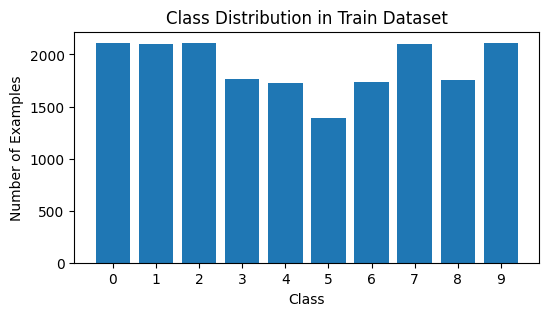

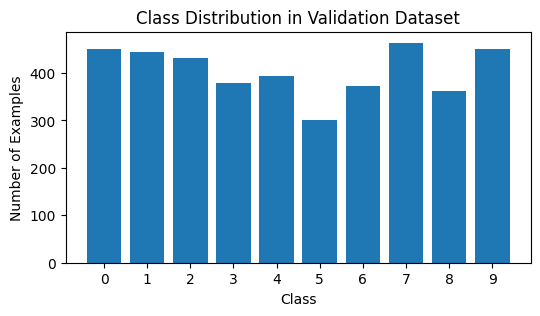

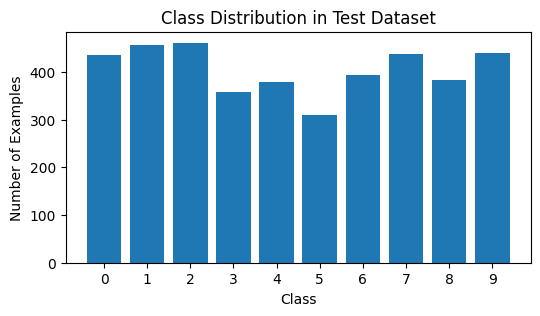

In [69]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the distribution of examples across output classes in a dataset.
    """
    # Initialize a counter for each class
    num_classes = dataset[0][1].shape[0]  # Assuming labels are tensors with shape [num_classes]
    class_counts = torch.zeros(num_classes)

    # Count occurrences for each class
    for _, label in dataset:
        class_counts += label

    # Convert counts to numpy for plotting
    class_counts = class_counts.numpy()

    # Plotting
    plt.figure(figsize=(6, 3))
    plt.bar(range(len(class_counts)), class_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of Examples")
    plt.title(title)
    plt.xticks(range(len(class_counts)))
    plt.show()

# Plot class distribution for train, val, and test datasets
plot_class_distribution(train_dataset, title="Class Distribution in Train Dataset")
plot_class_distribution(val_dataset, title="Class Distribution in Validation Dataset")
plot_class_distribution(test_dataset, title="Class Distribution in Test Dataset")


### Load the model

In [88]:
model = BigEarthNetv2_0_ImageClassifier.from_pretrained(
  "BIFOLD-BigEarthNetv2-0/resnet101-s2-v0.1.1"
)

In [ ]:
print(model.model)  # Check the structure of the ConfigILM model


ConfigILM(
  (vision_encoder): ResNet(
    (conv1): Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1

In [89]:
# Define the number of output classes for EuroSAT
num_classes = 10

# # Replace the final fully connected layer
# model.model.vision_encoder.fc = nn.Linear(
#     model.model.vision_encoder.fc.in_features, num_classes
# )

# Replace the final fully connected layer with a Dropout + Fully Connected Layer
model.model.vision_encoder.fc = nn.Sequential(
    nn.Dropout(p=0.1),  # Dropout with probability of 30%
    nn.Linear(model.model.vision_encoder.fc.in_features, num_classes)
)

# Verify the change
print(model.model.vision_encoder.fc)

Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=2048, out_features=10, bias=True)
)


### Freezing Layers


In [90]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model.model.vision_encoder.fc.parameters():
    param.requires_grad = True


Set up your optimizer to only optimize the unfreezed parameters

In [98]:
# Plot loss curves
def plot_loss_curves(training_losses, validation_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

Epoch 1/30
Training Loss: 0.4220
Validation Loss: 0.3205, Accuracy: 0.8998
Validation loss improved, resetting patience counter and saving model.
Current Learning Rate: 0.001000
Epoch 2/30
Training Loss: 0.4233
Validation Loss: 0.3351, Accuracy: 0.8923
Validation loss did not improve. Patience counter: 1
Current Learning Rate: 0.001000
Epoch 3/30
Training Loss: 0.4140
Validation Loss: 0.3223, Accuracy: 0.8946
Validation loss did not improve. Patience counter: 2
Current Learning Rate: 0.001000
Epoch 4/30
Training Loss: 0.4158
Validation Loss: 0.3241, Accuracy: 0.8928
Validation loss did not improve. Patience counter: 3
Current Learning Rate: 0.000500
Epoch 5/30
Training Loss: 0.4076
Validation Loss: 0.3201, Accuracy: 0.8970
Validation loss improved, resetting patience counter and saving model.
Current Learning Rate: 0.000500
Epoch 6/30
Training Loss: 0.4124
Validation Loss: 0.3146, Accuracy: 0.8980
Validation loss improved, resetting patience counter and saving model.
Current Learning R

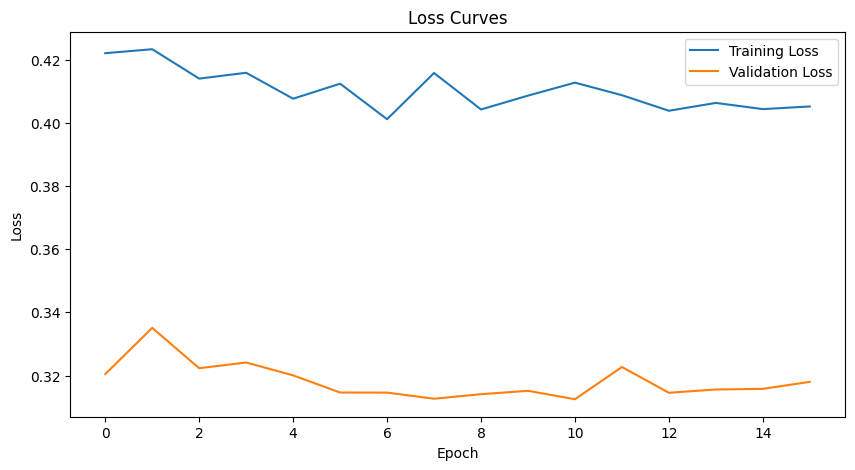

Training complete!


In [99]:
# Hyperparameters
num_epochs = 30
patience = 5  # Number of epochs to wait for improvement in early stopping
best_val_loss = float('inf')
patience_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Optimizer with lower weight decay
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-3)

# Loss Function
criterion = torch.nn.CrossEntropyLoss()

# Scheduler with increased patience
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Variables to store loss values
training_losses = []
validation_losses = []

# Training loop with ReduceLROnPlateau and early stopping
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Convert one-hot encoded labels to class indices
        labels = labels.argmax(dim=1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    training_losses.append(avg_loss)
    print(f"Training Loss: {avg_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Convert one-hot encoded labels to class indices
            labels = labels.argmax(dim=1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predicted class
            _, predicted_classes = torch.max(outputs, 1)
            correct_predictions += (predicted_classes == labels).sum().item()
            total_predictions += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)
    accuracy = correct_predictions / total_predictions
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Step the scheduler based on validation loss
    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Validation loss improved, resetting patience counter and saving model.")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience counter: {patience_counter}")
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

    # Log current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.6f}")


# Plot the loss curves after training
plot_loss_curves(training_losses, validation_losses)

print("Training complete!")


In [100]:
# Load the best model checkpoint
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Test evaluation
correct_predictions = 0
total_predictions = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Convert one-hot encoded labels to class indices
        labels = labels.argmax(dim=1)

        outputs = model(images)
        _, predicted_classes = torch.max(outputs, 1)

        # Collect predictions and labels for metrics
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted_classes.cpu().numpy())

        correct_predictions += (predicted_classes == labels).sum().item()
        total_predictions += labels.size(0)

test_accuracy = correct_predictions / total_predictions
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Generate classification report
from sklearn.metrics import classification_report

class_names = [f"Class {i}" for i in range(10)]  # Replace with actual class names if available
print(classification_report(all_labels, all_preds, target_names=class_names))


<ipython-input-100-84ff11d101ed>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Final Test Accuracy: 0.8948
              precision    recall  f1-score   support

     Class 0       0.85      0.89      0.87       436
     Class 1       0.97      0.99      0.98       456
     Class 2       0.89      0.91      0.90       461
     Class 3       0.69      0.59      0.64       358
     Class 4       0.88      0.94      0.91       378
     Class 5       0.91      0.90      0.90       309
     Class 6       0.87      0.86      0.87       393
     Class 7       0.92      0.94      0.93       437
     Class 8       0.92      0.89      0.90       383
     Class 9       0.99      0.98      0.99       439

    accuracy                           0.89      4050
   macro avg       0.89      0.89      0.89      4050
weighted avg       0.89      0.89      0.89      4050



In [95]:
print(labels.shape)


torch.Size([64, 10])


### Check DataSet statistics

In [64]:
def dataset_mean_std(dataset, dataset_name):
    """
    Compute and display the mean and standard deviation of a dataset.

    Args:
        dataset (Dataset): The PyTorch dataset to analyze.
        dataset_name (str): The name of the dataset (e.g., train, val, test).
    """
    print(f"Calculating statistics for {dataset_name} dataset...")

    # Initialize accumulators for mean and standard deviation
    mean_accumulator = 0
    std_accumulator = 0
    num_samples = 0

    for images, _ in dataset:
        # Reshape images to (N, C, H, W)
        images = images.view(images.size(0), -1)  # Flatten to (N, Pixels)
        mean_accumulator += images.mean(dim=1).sum()  # Sum means of samples
        std_accumulator += images.std(dim=1).sum()   # Sum std of samples
        num_samples += images.size(0)

    # Compute final mean and standard deviation
    dataset_mean = mean_accumulator / num_samples
    dataset_std = std_accumulator / num_samples

    print(f"Dataset: {dataset_name}")
    print(f"Mean: {dataset_mean:.4f}")
    print(f"Standard Deviation: {dataset_std:.4f}")
    print("-" * 30)


In [72]:
dataset_mean_std(train_loader, "train")  # Pass DataLoader for batched datasets
dataset_mean_std(val_loader, "validation")
dataset_mean_std(test_loader, "test")

Calculating statistics for train dataset...
Dataset: train
Mean: 0.2535
Standard Deviation: 0.7553
------------------------------
Calculating statistics for validation dataset...
Dataset: validation
Mean: 0.2486
Standard Deviation: 0.7561
------------------------------
Calculating statistics for test dataset...
Dataset: test
Mean: 0.2489
Standard Deviation: 0.7511
------------------------------
